# Evaluating Your Trained QC Model

Welcome! This notebook is a step-by-step guide to testing the quality control model you've trained. The goal is to load your model, give it a sample image, and see how well it can detect the anomalies. We use the pDDPM model here so make sure you have downloaded the pre-trained pDDPM checkpoint.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Setup: Installing Necessary Libraries

First, we need to make sure we have all the required Python libraries. The cell below will install them for you. This might take a few minutes to complete. Skip it if you have already created an environment with all required libaries installed. You may need to restart the runtime in order to use newly installed versions, if you are using google colab.

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 --index-url https://download.pytorch.org/whl/cu118

with open("requirements.txt", "w") as f:
    f.write("""
pytorch-lightning==1.5.1
monai==1.0.1
torchio==0.19.1
SimpleITK==2.2.1
nibabel==3.2.1
matplotlib==3.5.2
seaborn==0.11.2
numpy==1.26.4
pandas==2.2.3
scikit-learn==1.3.0
scipy==1.13.1
opencv-python==4.7.0.72
omegaconf==2.1.2
timm==0.6.7
transformers==4.26.1
huggingface-hub==0.23.2
einops==0.4.1
grad-cam==1.3.7
ema-pytorch==0.0.8
torchgeometry==0.1.2
tqdm
requests
""")

!pip install -r requirements.txt

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 343.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 35.2/35.2 MB 221.8 MB/s eta 0:00:01^C


In [ ]:
%cd /content/drive/MyDrive/AutoQC/

## 2. Configuration

Every model needs a set of instructions or settings to work correctly. These are called "hyperparameters". We need to define them here, making sure they match the settings used when the model was trained.

**You don't need to change these** unless you know they are different from the ones used in your training.

In [3]:
from omegaconf import OmegaConf

cfg = OmegaConf.create({
    # --- General settings ---
    'imageDim': [192, 192, 1], # The size of the images [Height, Width, Depth]
    'rescaleFactor': 8,
    'objective': 'pred_x0',   # The prediction objective of the diffusion model
    'inpaint': True,         # Whether the model is for inpainting

    # --- UNet Model settings ---
    'unet_dim': 128,             # Base dimension of the U-Net
    'num_res_blocks': 3,        # Number of residual blocks
    'dim_mults': [1, 2, 2],  # Dimension multipliers for U-Net levels
    'num_heads': 1,
    'dropout_unet': 0,

    # --- Diffusion Model settings ---
    'timesteps': 1000,          # Total diffusion timesteps during training
    'test_timesteps': 50,      # Timesteps to use for testing/inference
    'loss': 'l1+ssim',
    'p2_gamma': 0,

    # --- Patch/Box settings ---
    'patch_size': 96,  # Size of patches
    'grid_boxes': True,      # Whether to sample boxes from a grid
    'noisetype': 'simplex',
})

print("Configuration is set up!")

Configuration is set up!


## 3. Defining the Building Blocks

To make this notebook self-contained and easier to run, we will copy all the necessary code pieces into the cell below.

In [4]:
# Import all the main libraries we'll need
import torch
import torch.optim as optim
import torchio as tio
import pytorch_lightning as pl
import numpy as np
import SimpleITK as sitk
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from typing import Any, List
import matplotlib.pyplot as plt
from multiprocessing import Manager

# --- Code from DDPM_2D_patched.py and its dependencies ---
# NOTE: The following classes (GaussianDiffusion, UNetModel) are standard implementations
# for diffusion models. For this notebook to work, they must match the architecture
# of the model you trained.

# Placeholder/dummy implementations for model components.
# You should replace these with the actual code from your 'src' directory if possible.
from src.models.modules.cond_DDPM import GaussianDiffusion
from src.models.modules.OpenAI_Unet import UNetModel as OpenAI_UNet
from src.utils.utils_eval import _test_step, _test_end, get_eval_dictionary
from src.utils.patch_sampling import BoxSampler
from src.utils.generate_noise import gen_noise

class DDPM_2D(pl.LightningModule):
    def __init__(self,cfg,prefix=None):
        super().__init__()

        self.cfg = cfg
        model = OpenAI_UNet(
                            image_size =  (int(cfg.imageDim[0] / cfg.rescaleFactor),int(cfg.imageDim[1] / cfg.rescaleFactor)),
                            in_channels = 1,
                            model_channels = cfg.get('unet_dim',64),
                            out_channels = 1,
                            num_res_blocks = cfg.get('num_res_blocks',3),
                            attention_resolutions = (int(cfg.imageDim[0])/int(32),int(cfg.imageDim[0])/int(16),int(cfg.imageDim[0])/int(8)),
                            dropout=cfg.get('dropout_unet',0),
                            channel_mult=cfg.get('dim_mults',[1, 2, 4, 8]),
                            conv_resample=True,
                            dims=2,
                            num_classes=None,
                            use_checkpoint=True,
                            use_fp16=True,
                            num_heads=cfg.get('num_heads',1),
                            num_head_channels=64,
                            num_heads_upsample=-1,
                            use_scale_shift_norm=True,
                            resblock_updown=True,
                            use_new_attention_order=True,
                            use_spatial_transformer=False,
                            transformer_depth=1,
                            )

        model.convert_to_fp16()

        timesteps = cfg.get('timesteps',1000)
        self.test_timesteps = cfg.get('test_timesteps',50)
        sampling_timesteps = cfg.get('sampling_timesteps',self.test_timesteps)

        self.diffusion = GaussianDiffusion(
        model,
        image_size = (int(cfg.imageDim[0] / cfg.rescaleFactor),int(cfg.imageDim[1] / cfg.rescaleFactor)),
        timesteps = timesteps,
        sampling_timesteps = sampling_timesteps,
        objective = cfg.get('objective','pred_x0'),
        channels = 1,
        loss_type = cfg.get('loss','l1'),
        p2_loss_weight_gamma = cfg.get('p2_gamma',0),
        inpaint = cfg.get('inpaint',False),
        cfg=cfg
        )

        self.boxes = BoxSampler(cfg)
        self.prefix = prefix
        self.save_hyperparameters()

    def forward(self, x):
        # The real forward pass happens inside the diffusion model
        # For inference, we will call a specific method on the diffusion object
        pass

# --- Code from create_dataset.py ---

def sitk_reader(path):
    image_nii = sitk.ReadImage(str(path), sitk.sitkFloat32)
    if not 'mask' in str(path) and not 'seg' in str(path):  # only for volumes / scalar images
        image_nii = sitk.CurvatureFlow(image1=image_nii, timeStep=0.125, numberOfIterations=3)
    vol = sitk.GetArrayFromImage(image_nii)
    if len(vol.shape) == 2:
        vol = np.expand_dims(vol, axis=2)
    return vol, None

def get_transform(cfg, state='eval'):  # Transforms for evaluation
    h, w, d = tuple(cfg.get('imageDim', (256, 256, 1)))
    preprocess = tio.Compose([
            tio.RescaleIntensity(
                (0, 1),
                percentiles=(cfg.get('perc_low', 0), cfg.get('perc_high', 100)),
                include=('vol', 'vol_orig')
            )
        ])
    return preprocess

def EvalDataset(csv_path, cfg):
    df = pd.read_csv(csv_path)
    subjects = []
    for _, sub in df.iterrows():
        subject_dict = {
            'vol': tio.ScalarImage(sub.img_path, reader=sitk_reader),
            'vol_orig': tio.ScalarImage(sub.img_path, reader=sitk_reader),
            'seg_available': False,
            'ID': sub.img_path.split('/')[-2],
            'ved_num': sub.img_path.split('/')[-1].split('.')[0],
            'label': sub.label,
            'Dataset': 'test',
            'stage': 'test',
            'path': sub.img_path
        }
        if sub.seg_path != None and not isinstance(sub.seg_path, float) :  # if we have segmentations
            subject_dict['seg'] = tio.LabelMap(sub.seg_path, reader=sitk_reader),
            subject_dict['seg_orig'] = tio.LabelMap(sub.seg_path,
                                                    reader=sitk_reader)  # we need the image in original size for evaluation
            subject_dict['seg_available'] = True

        subject = tio.Subject(subject_dict)
        subjects.append(subject)
    ds = tio.SubjectsDataset(subjects, transform=get_transform(cfg, state='eval'))
    return ds

## 4. Loading the Model

Now, we'll load the trained weights into the model's structure.

**Action Required**: You must change `path_to_your_model` to the actual file path of your trained model checkpoint (it usually ends with `.ckpt` or `.pt`).

In [5]:
# !!! IMPORTANT !!!
# V V V V V V V V V
path_to_your_model = '/content/drive/MyDrive/Cell_Anomaly_Detection_Benchmark/AutoQC/checkpoints/pddpm_complexeye.ckpt' # <-- CHANGE THIS to the path of your model file
# ^ ^ ^ ^ ^ ^ ^ ^ ^
# !!!!!!!!!!!!!!!!!

if not os.path.exists(path_to_your_model):
    print("ERROR: Model file not found!")
    print(f"Please make sure the path '{path_to_your_model}' is correct.")
else:
    print("Loading model structure...")
    model = DDPM_2D(cfg)

    print(f"Loading trained weights from {path_to_your_model}...")
    checkpoint = torch.load(path_to_your_model, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])

    # Set the model to evaluation mode (important for testing)
    model.eval()

    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print("\nModel loaded successfully!")
    print(f"Model is running on: {device}")

Loading model structure...
Loading trained weights from /content/drive/MyDrive/Cell_Anomaly_Detection_Benchmark/AutoQC/checkpoints/pddpm_complexeye.ckpt...

Model loaded successfully!
Model is running on: cuda:0


## 5. Preparing Data

To test the model, we provide one positive sample and one negative sample (with anomalies and its corresponding mask).

In [43]:
data_dir = './example_data/example_test.csv'
# Create the dataset and dataloader
test_dataset = EvalDataset(csv_path=data_dir, cfg=cfg)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloader_iter = iter(test_dataloader)
print("Test data loader is ready!")

Test data loader is ready!


## 6. Running the Model (Inference)

Run 6 and 7 again for the next sample.

In [44]:
print("Getting one sample from the dataloader...")
batch = next(dataloader_iter)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get the input image and move it to the correct device (CPU or GPU)
print(batch['ved_num'])
input_image = batch['vol'][tio.DATA].float().to(device)

# The model expects the image in a specific shape (D, C, H, W)
input_image_permuted = input_image.squeeze(0).permute(3,0,1,2)

print(f"Input image shape: {input_image_permuted.shape}")
print("Running inference... This may take a moment.")

# Define the function that generates the reconstruction for a given window/patch
def generate_rec(window):
    bbox = model.boxes.sample_grid(window)
    reco_patched = torch.zeros_like(window)

    for k in range(bbox.shape[1]):
        box = bbox[:,k]
        _, reco = model.diffusion(window, t=model.test_timesteps-1, box=box, noise=None)
        if reco.shape[1] == 2: # Handle models that output variance
            reco = reco[:,0:1,:,:]
        for j in range(reco_patched.shape[0]):
             reco_patched[j,:,box[j,1]:box[j,3],box[j,0]:box[j,2]] = reco[j,:,box[j,1]:box[j,3],box[j,0]:box[j,2]]
    return reco_patched

# Run the sliding window inference
with torch.no_grad(): # Disable gradient calculations to save memory and speed up
    reconstruction = sliding_window_inference(
        inputs=input_image_permuted,
        predictor=generate_rec,
        roi_size=(cfg.patch_size, cfg.patch_size),
        sw_batch_size=1,
        overlap=0.5, # How much patches overlap, 0.5 is a good default
        mode="gaussian" # How to blend overlapping regions
    )

print("Inference complete!")

Getting one sample from the dataloader...
['01_A1_f300']
Input image shape: torch.Size([1, 1, 800, 1280])
Running inference... This may take a moment.
Inference complete!


## 7. Viewing the Results

Let's see what the model did.

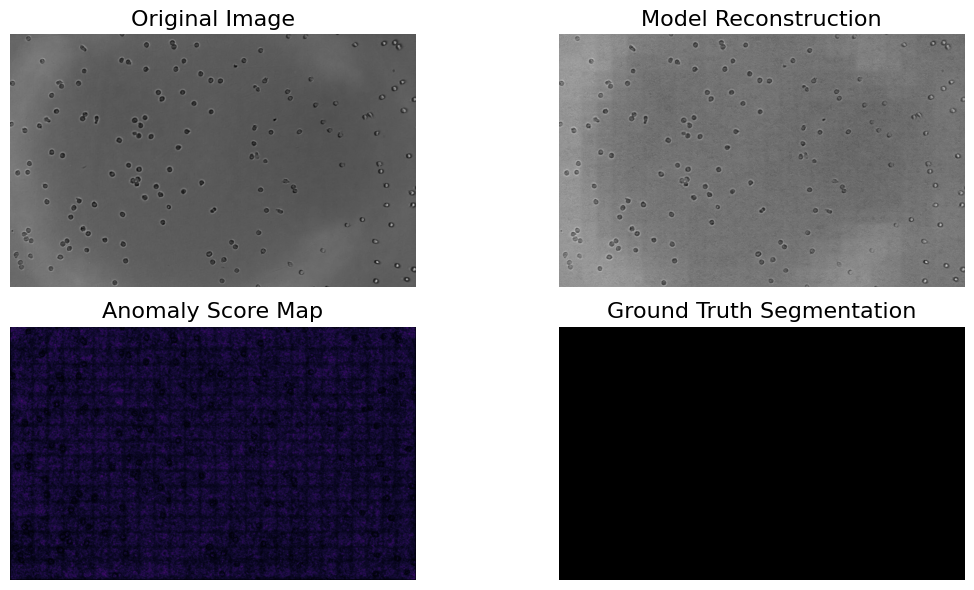

Anomaly Score: 0.14905604720115662


In [45]:
import torchgeometry as tgm

diff_img = torch.abs((input_image_permuted.squeeze(0)-reconstruction.unsqueeze(0))).squeeze(0)
ssim = tgm.losses.SSIM(window_size=5,reduction='none')
diff_img_ssim = ssim(input_image_permuted,reconstruction)


diff_img_tmp = 0.5 * diff_img_ssim + 0.5 * diff_img
diff_img = diff_img_tmp

# Squeeze out single dimensions and move to CPU for plotting
original_for_plot = input_image_permuted.squeeze().cpu().numpy()
reconstruction_for_plot = reconstruction.squeeze().cpu().numpy()
diff_img = diff_img.squeeze().cpu().numpy()

# If we have segmentation
if 'seg' in batch:
  img_seg = batch['seg_orig'][tio.DATA].squeeze().cpu().numpy()

# Create a plot to compare the two images
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot Original Image
axes[0,0].imshow(original_for_plot, cmap='gray')
axes[0,0].set_title('Original Image', fontsize=16)
axes[0,0].axis('off') # Hide axes ticks

# Plot Reconstructed Image
axes[0,1].imshow(reconstruction_for_plot, cmap='gray')
axes[0,1].set_title('Model Reconstruction', fontsize=16)
axes[0,1].axis('off') # Hide axes ticks

# Plot Anomaly Score Map
axes[1,0].imshow(diff_img, cmap='inferno', vmin=0, vmax=1)
axes[1,0].set_title('Anomaly Score Map', fontsize=16)
axes[1,0].axis('off') # Hide axes ticks

# Plot GT Segmentation
if 'seg' in batch:
  axes[1,1].imshow(img_seg, cmap='gray')
  axes[1,1].set_title('Ground Truth Segmentation', fontsize=16)
  axes[1,1].axis('off') # Hide axes ticks
else:
  # all black
  axes[1,1].imshow(np.zeros_like(diff_img), cmap='gray')
  axes[1,1].set_title('Ground Truth Segmentation', fontsize=16)
  axes[1,1].axis('off') # Hide axes ticks

plt.tight_layout()
plt.show()

# Calculate a simple anomaly metric
# use sliding window for anomaly score (report the largest anomaly score in the window)
h, w = diff_img.squeeze().shape
window_size = 16
stride = 8
AnomalyScorePatch = []
for i in range(0, h - window_size + 1, stride):
    for j in range(0, w - window_size + 1, stride):
        AnomalyScorePatch.append(diff_img.squeeze()[i:i + window_size, j:j + window_size].mean())
AnomalyScorePatch_overall = np.max(AnomalyScorePatch)
print(f"Anomaly Score: {AnomalyScorePatch_overall}")